In [31]:
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from trainer import Trainer
from logger import Logger

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_15min.csv'

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コードをcategoryデータに
    - degreeをint32
    - 0/1系をint32

In [365]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [368]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
        'direction': np.int32,
        'quarter': np.int32,
        'jam_quantity': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [4]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)
    

# whole dataset
# start_date = '2021/5/1'
# end_date = '2022/6/1'
# pkl_name = './datasets/kannetsu_210501-220601.pkl'

# create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
# start_date = '2021/5/1'
# end_date = '2021/6/1'
# pkl_name = './datasets/kannetsu_210501-210601.pkl'

# create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [5]:
# mini
df_test = pd.read_pickle('./datasets/kannetsu_210501-210601.pkl')

# whole
# df_all = pd.read_pickle('./datasets/kannetsu_210501-220601.pkl')

In [6]:
df_test.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,search_unspec_3d,search_unspec_7d,search_unspec_10d,minute_quarter,allCars,jam_quantity,search_15min,OCC,speed,year
0,2021-05-01,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.806149,35.755821,139.535507,...,6411.0,14134.0,18949.0,0,211.0,0,6.0,0.023333,91.289101,2021
1,2021-05-01,小出,大和ＰＡ,1800156,1800151,15,15,37.213329,37.160999,138.975403,...,2446.0,5418.0,7059.0,0,23.0,0,1.0,0.000000,94.869568,2021
2,2021-05-01,六日町,塩沢石打,1800146,1800141,15,15,37.077942,36.990280,138.879288,...,2439.0,5339.0,6888.0,0,26.0,0,1.0,0.000000,91.961540,2021


## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [7]:
key_col = ['datetime', 'start_name', 'end_name']

# 特徴量の元になる列
time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
section_col = ['direction', 'lane_count', 'KP']
search_col = ['search_15min']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [8]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.head(3)

sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [9]:
# データ数
N = df_test.shape[0]
# 区間数
N_sec = sec_table.shape[0]
# 時系列長
N_period = N // N_sec
print(N, N_sec, N_period)

# 特徴量数
D = len(feature_col)

# 行列を準備
X = torch.empty((N_sec, N_period, D), dtype=torch.float32)
y = torch.empty((N_sec, N_period, 1), dtype=torch.float32)

# 行列に区間ごとに値を入れていく
for sec_id, (s_name, e_name, direction, _) in sec_table.iterrows():
    query = f'start_name == "{s_name}" & end_name == "{e_name}" & direction == {direction}'
    df_sec = df_test.query(query)
    
    data = df_sec.loc[:, feature_col]
    target = df_sec.loc[:, target_col]
    X[sec_id] = torch.from_numpy(data.values)
    y[sec_id, :, 0] = torch.from_numpy(target.values)
    
print(X.shape, X.dtype, y.shape, y.dtype)

187488 63 2976
torch.Size([63, 2976, 9]) torch.float32 torch.Size([63, 2976, 1]) torch.float32


## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [10]:
def cyclic_encode(X):
    eps = 1e-8
    max_v, _ = X.view(-1, X.shape[-1]).max(dim=0)
    X_cos = torch.cos(2 * torch.pi * X) / (max_v + eps)
    X_sin = torch.sin(2 * torch.pi * X) / (max_v + eps)
    return X_cos, X_sin

In [11]:
class STMatrixStandardScaler:
    _direction_col = 4
    _eps = 1e-8
    
    def __init__(self, by_up_down=False):
        self.by_up_down = by_up_down
    
    def fit(self, X):
        assert X.dim() == 3, 'X should be Spatial-Temporal Matrix (Sections x Periods x Features)'
        S, T, D = X.shape
        
        if self.by_up_down:
            X_up = X[X[..., self._direction_col] == 0].view(-1, T, D)
            X_down = X[X[..., self._direction_col] == 1].view(-1, T, D)
            
            mean_up, std_up = self.__calc_params(X_up)
            mean_down, std_down = self.__calc_params(X_down)
            
            self.mean_ = (mean_up, mean_down)
            self.std_ = (std_up, std_down)
        else:
            mean, std = self.__calc_params(X)
            self.mean_ = mean
            self.std_ = std
    
    def transform(self, X):
        S, T, D = X.shape
        
        if self.by_up_down:
            X_up = X[X[..., self._direction_col] == 0].view(-1, T, D)
            X_down = X[X[..., self._direction_col] == 1].view(-1, T, D)
            
            X_up_norm = self.__transform(X_up, self.mean_[0], self.std_[0])
            X_down_norm = self.__transform(X_down, self.mean_[1], self.std_[1])
            
            X_norm = np.vstack((X_up_norm, X_down_norm))
        else: 
            X_norm = self.__transform(X, self.mean_, self.std_)
            
        return X_norm
    
    def fit_transform(self, X):
        self.fit(X)
        X_norm = self.transform(X)
        return X_norm
        
    def inverse_transform(self, X):
        X_origin = X * (self.std_ + self._eps) + self.mean_
        return X_origin
    
    def get_params(self):
        params = {'mean': self.mean_, 'std': self.std_}
        return params
    
    def __calc_params(self, X):
        S, T, D = X.shape
        mean = X.reshape(-1, D).mean(axis=0)
        std = X.reshape(-1, D).std(axis=0)
        return mean, std
        
    def __transform(self, X, mean, std):
        X_norm = (X - mean) / (std + self._eps)
        return X_norm

In [12]:
scaler = STMatrixStandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

In [13]:
def train_test_split(X, y, test_ratio):
    assert X.dim() == 3, 'X should be Spatial-Temporal Matrix (Sections x Periods x Features)'
    _, T, _ = X.shape
    index_split = int(T * test_ratio)
    X_train, X_test = X[:, :-index_split], X[:, -index_split:]
    y_train, y_test = y[:, :-index_split], y[:, -index_split:]
    
    return X_train, X_test, y_train, y_test

In [14]:
test_ratio = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_ratio)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([63, 2381, 9]) torch.Size([63, 2381, 1])
torch.Size([63, 595, 9]) torch.Size([63, 595, 1])


In [15]:
# A-B-C-D x 各区間10個ずつ
# batch_size = 2
# time_step = 3

# AB0, AB1, AB2, ..., AB9
# BC0, BC1, BC2, ..., BC9
# CD0, CD1, CD2, ..., CD9

# ABに限定するのであれば
# [AB0, AB1, AB2], [AB1, AB2, AB3], ..., [AB7, AB8, AB9] -> 7個できる

# バッチ数を区間数の倍数にすればいい？
# [[AB0, AB1, AB2]
# [BC0, BC1, BC2]
# [CD0, CD1, CD2]]

# 下みたいに区間に対応するラベルさえしっかり出力できるなら問題ない
# [[AB0, AB1, AB2] -> AB3
# [AB1, AB2, AB3] -> AB4
# [AB5, AB6, AB7] -> AB8
# [BC2, BC3, BC4] -> BC5
# [BC7, BC8, BC9] -> BC10
# [CD0, CD1, CD2]] -> CD3

## データセットの定義

In [16]:
# dataset
# 必要なもの: X, y, time_window, space_window, prediction_horizon

class STDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, time_step, prediction_horizon=1, space_window=None):
        '''
        Parameters
        ----------
        X:
        y:
        time_step: int
            過去を参照する時間幅 (x 15min)
        prediction_horizon: int
            いくつ先のstepを予測するか (>= 1 x 15min)
        space_window: Tuple
            前後の区間をいくつ参照するか
        '''
        assert X.dim() == 3, 'X should be Spatial-Temporal Matrix (Sections x Periods x Features)'
        assert y.dim() == 3, 'y should be Spatial-Temporal Matrix (Sections x Periods x 1 (label))'
        
        assert time_step > 0, 'time step must be >0 (x15min)'
        assert prediction_horizon > 0, 'prediction horizon must be >0 (x15min)'
        
        self.time_step = time_step
        self.space_window = space_window
        self.prediction_horizon = prediction_horizon
        
        if space_window is not None:
            assert isinstance(space_window, (list, tuple)), 'space window must be List[int] or Tuple[int]'
            assert isinstance(space_window[0], int), 'space window must be List[int] or Tuple[int]'
            assert len(space_window) == 2, 'space window must be (-upstream_step, downstream_step)'
            f, l = self.__sliding_space(X, y)
            features, labels = self.__sliding_window(f, l)
        else:
            features, labels = self.__sliding_window(X, y)
            
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __sliding_space(self, X, y):
        S, T, D = X.shape
        s_window = self.space_window
        s_len = s_window[1] - s_window[0] + 1
        
        features = torch.empty((S, T, D, s_len), dtype=torch.float32)
        labels = torch.empty((S, T, 1, s_len), dtype=torch.float32)
        
        for i in range(S):
            # 各区間の前後区間を切り出す
            for offset in range(s_window[0], s_window[1]+1):
                j = i + offset
                # paddingする
                if j < 0:
                    j = 0
                elif j >= S:
                    j = S-1

                features[i, ..., offset] = X[j]
                labels[i, ..., offset] = y[j]
        
        return features, labels
        
    
    def __sliding_window(self, X, y):
        S, T, *_ = X.shape
        t_step = self.time_step
        p_horizon = self.prediction_horizon
        
        features = []
        labels = []
        for i in range(S):
            # 各区間ごとに過去time step分だけ切り出す
            for t in range(t_step, T - p_horizon + 1):
                feature = X[i, t-t_step:t+p_horizon-1]
                label = y[i, t+p_horizon-1]
                features.append(feature)
                labels.append(label)

        features = torch.cat(features, dim=0).view(len(features), *features[0].shape)
        labels = torch.cat(labels, dim=0).view(len(labels), *labels[0].shape)

        return features, labels

In [17]:
time_step = 96
prediction_horizon = 1
space_window = None

dataset_train = STDataset(X_train, y_train, time_step=time_step, prediction_horizon=prediction_horizon)
dataset_valid = STDataset(X_val, y_val, time_step=time_step, prediction_horizon=prediction_horizon)

## ネットワークの定義

In [18]:
class Net(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, out_dim)
    
    def forward(self, x):
        outs, (h, c) = self.lstm(x)
        out = self.fc(h[0])
        return out

## 学習

In [19]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [20]:
n_epochs = 150
in_dim = X_train.shape[-1]
hid_dim = 32
out_dim = 1
num_layers = 1

model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.L1Loss()

In [22]:
# model_path = './models/simpleLSTM_150.pth'
# model.load_state_dict(torch.load(model_path))

In [23]:
logger = Logger()
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger)

In [38]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=20, max_first_log_steps=5)

2022-08-06 03:20:09.021559 | Epoch: 1 | Train Loss: 200.575, Train Time: 2.74 [sec] | Valid Loss: 184.510, Valid Time: 0.32 [sec]
2022-08-06 03:20:12.083290 | Epoch: 2 | Train Loss: 183.791, Train Time: 2.61 [sec] | Valid Loss: 170.499, Valid Time: 0.45 [sec]
2022-08-06 03:20:15.141265 | Epoch: 3 | Train Loss: 172.137, Train Time: 2.74 [sec] | Valid Loss: 161.208, Valid Time: 0.32 [sec]
2022-08-06 03:20:18.328505 | Epoch: 4 | Train Loss: 162.574, Train Time: 2.87 [sec] | Valid Loss: 149.412, Valid Time: 0.32 [sec]
2022-08-06 03:20:21.269778 | Epoch: 5 | Train Loss: 150.111, Train Time: 2.62 [sec] | Valid Loss: 138.959, Valid Time: 0.32 [sec]
2022-08-06 03:21:06.938881 | Epoch: 20 | Train Loss: 60.646, Train Time: 2.66 [sec] | Valid Loss: 54.852, Valid Time: 0.32 [sec]
2022-08-06 03:22:08.107499 | Epoch: 40 | Train Loss: 23.828, Train Time: 2.75 [sec] | Valid Loss: 21.290, Valid Time: 0.32 [sec]
2022-08-06 03:23:09.465650 | Epoch: 60 | Train Loss: 16.421, Train Time: 2.80 [sec] | Valid 

### 学習曲線

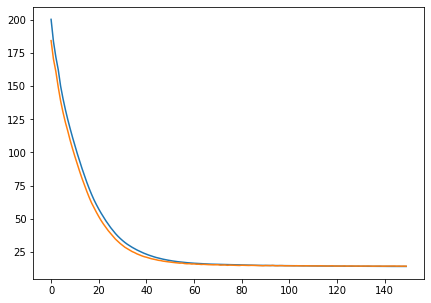

In [39]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(train_losses)), train_losses)
ax.plot(range(len(val_losses)), val_losses)
plt.show()

In [24]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

13.726758399611045
14.061335032548362


In [181]:
# model_path = './models/simpleLSTM_150.pth'
# torch.save(model.state_dict(), model_path)

## 予測結果

In [25]:
start_date = pd.Timestamp('2021/5/28') - dt.timedelta(minutes=15) * time_step
end_date = pd.Timestamp('2021/6/1') - dt.timedelta(minutes=15)

In [26]:
S = sec_table.shape[0]
T = int((end_date - start_date).total_seconds() // (60 * 15))
D = len(feature_col)

X_test = torch.empty((S, T, D), dtype=torch.float32)
y_test = torch.empty((S, T, 1), dtype=torch.float32)

for sec_id, (s_name, e_name, *_) in sec_table.iterrows():
    query = f'start_name == "{s_name}" & end_name == "{e_name}"'
    df_sec = df_test.query(f'start_name == "{s_name}" & end_name == "{e_name}"')
    df_sec = df_sec[(df_sec['datetime'] >= start_date) & (df_sec['datetime'] < end_date)]
    
    data = df_sec.loc[:, feature_col].values
    target = df_sec.loc[:, target_col].values
    
    X_test[sec_id] = torch.from_numpy(data)
    y_test[sec_id, :, 0] = torch.from_numpy(target)
    
X_test = scaler.transform(X_test)

dataset_test = STDataset(X_test, y_test, time_step=time_step, prediction_horizon=prediction_horizon)

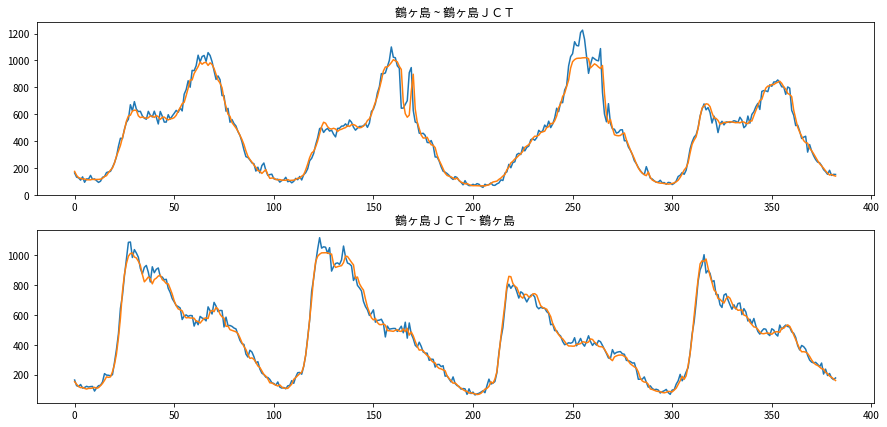

In [28]:
data = dataset_test[:][0].to(device=device)

with torch.no_grad():
    pred = model(data)

pred = pred.view(S, -1).to(device='cpu')
target = dataset_test[:][1].view(S, -1).to(device='cpu')

plot_sections = [27, 36]
fig, axes = plt.subplots(len(plot_sections), 1, figsize=(15, 7))
for i, sec_id in enumerate(plot_sections):
    axes[i].plot(target[sec_id], label='true')    
    axes[i].plot(pred[sec_id], label='pred')
    
    title = f'{sec_table.loc[sec_id, "start_name"]} ~ {sec_table.loc[sec_id, "end_name"]}'
    axes[i].set_title(title)

In [263]:
tmp_train = df_test[(df_test['start_name'] == '鶴ヶ島') & (df_test['direction'] == 1)]
tmp_train = tmp_train.loc[:, key_col + features]

# 時系列長
N_period = tmp_train.drop_duplicates("datetime").shape[0]
# 区間数
N_sec = tmp_train.drop_duplicates(["start_name", "end_name"]).shape[0]
# 特徴量数
D = len(features)

tmp_train_value = tmp_train[features].values.reshape(1, N_period, D)
tmp_train_norm = (tmp_train_value - X_mean) / X_std

In [264]:
tmp_X = []

for i in range(N_sec):
    for t in range(time_step, N_period - 24):
        time_pred = t + 24
        time_input = (t - time_step, t + time_step + 1)
        x_ = tmp_train_norm[i, time_input[0] : time_input[1]]
        tmp_X.append(x_)

tmp_X = torch.from_numpy(np.array(tmp_X, dtype=np.float32))

In [265]:
tmp_pred = model(tmp_X.to(device=device))

In [266]:
ys = np.arange(time_step, N_period - 24) + 24
tmp_y = tmp_train.iloc[ys, -1].values.reshape(-1, 1)
tmp_y = torch.from_numpy(tmp_y).to(device=device)

In [269]:
tmp_y[-10:]

tensor([[2830.],
        [2699.],
        [2518.],
        [2320.],
        [2056.],
        [1892.],
        [1657.],
        [1534.],
        [1343.],
        [ 890.]], device='cuda:0')

In [270]:
tmp_pred[-10:]

tensor([[1906.3523],
        [2111.0740],
        [1478.2659],
        [1709.9409],
        [1561.3125],
        [1184.2350],
        [1547.8439],
        [1354.0841],
        [ 719.4714],
        [ 688.2144]], device='cuda:0', grad_fn=<SliceBackward0>)

In [399]:
with torch.no_grad():
    i = 0
    for data, target in dataset_train:
        if i >= 10:
            break
        i += 1
        print(f'------- {i} -------')
        out = model(data.to(device=device))
        print(target)
        print(out)
        print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())
        print()

------- 1 -------
tensor(126.)
tensor([115.0645], device='cuda:0')
10.935508728027344

------- 2 -------
tensor(134.)
tensor([134.9498], device='cuda:0')
0.9497833251953125

------- 3 -------
tensor(170.)
tensor([168.9665], device='cuda:0')
1.0334625244140625

------- 4 -------
tensor(198.)
tensor([204.4083], device='cuda:0')
6.4083099365234375

------- 5 -------
tensor(179.)
tensor([184.3132], device='cuda:0')
5.313201904296875

------- 6 -------
tensor(202.)
tensor([209.7910], device='cuda:0')
7.79095458984375

------- 7 -------
tensor(224.)
tensor([240.2662], device='cuda:0')
16.266204833984375

------- 8 -------
tensor(317.)
tensor([303.8457], device='cuda:0')
13.154327392578125

------- 9 -------
tensor(383.)
tensor([374.0816], device='cuda:0')
8.918426513671875

------- 10 -------
tensor(440.)
tensor([439.5305], device='cuda:0')
0.469482421875



/tmp/ipykernel_65/1850680170.py:11: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(torch.sqrt(nn.functional.mse_loss(out, target.to(device=device))).item())


In [339]:
n_epochs = 3000
in_dim = X_train.shape[-1]
hid_dim = 100
out_dim = 1
num_layers = 1

model = Net(in_dim, hid_dim, out_dim, num_layers).to(device=device)
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    total_loss = 0
    for data, target in train_loader:
        data = data.to(device=device)
        target = target.unsqueeze(1).to(device=device)
        
        out = model(data)
        loss = loss_fn(out, target)
        total_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(total_loss)

    if epoch < 3 or (epoch + 1) % 100 == 0:
        print(f'{dt.datetime.now()} | Epoch {epoch+1} | Loss: {loss}')

2022-07-21 17:24:34.155558 | Epoch 1 | Loss: 65953.34375
2022-07-21 17:24:40.475783 | Epoch 2 | Loss: 6871.1943359375
2022-07-21 17:24:46.874386 | Epoch 3 | Loss: 11021.1640625


KeyboardInterrupt: 